# Wstęp
Narzędziem wykorzystywanym w projekcie jest język Python wraz ze swoją biblioteką `pandas`, przeznaczoną do analizy danych. Niniejszy raport przygotowano w środowisku `jupyter`, które udostępnia przeglądarkowy interfejs z jądrem obliczeniowym Pythona. Można tam w łatwy sposób wykonywać kod i od razu uzyskiwać wyniki czy wykresy, a także przeplatać komórki kodu z komórkami tekstu formatowanymi zgodnie z językiem `markdown`, co nadaje całemu dokumentowi przystępną w odbiorze formę.

Na początku zaimportowano potrzebne biblioteki.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon, bartlett, ttest_ind, mannwhitneyu, f_oneway
plt.rcParams['figure.figsize'] = [10, 5]

Do typowej dla biblioteki `pandas` struktury danych `DataFrame` wczytano pierwszy zbiór danych analizowany w projekcie, tj. *crime.csv*. Został on pobrany spośród wielu zbiorów danych udostępnionych przez Uniwersytet Sheffield pod [tym](https://www.sheffield.ac.uk/mash/statistics/datasets) adresem . Następnie sprawdzono, czy gdziekolwiek w zbiorze występują puste wartości wymagające uzupełnienia -- nie stwierdzono takiego przypadku.

In [69]:
df = pd.read_csv('crime.csv')
print(df.isnull().values.any(), df.isna().values.any())

False False


Dane opisują przestępczość w Stanach Zjednoczonych, tj. dla każdego stanu dysponujemy próbką zawierającą wartość współczynnika przestępczości w tym stanie i szereg dodatkowych czynników. Dane zebrano w pewnym punkcie czasu, a także 10 lat później, co uwzględniono w nazwach kolumn struktury `DataFrame` (liczba 10 na końcu oznacza, że dane w tej kolumnie są późniejsze). Obserwacje przechowywane są albo jako liczby całkowite, albo zmiennoprzecinkowe.

In [70]:
print(df.dtypes)

CrimeRate              float64
Youth                    int64
Southern                 int64
Education              float64
ExpenditureYear0         int64
LabourForce              int64
Males                    int64
MoreMales                int64
StateSize                int64
YouthUnemployment        int64
MatureUnemployment       int64
HighYouthUnemploy        int64
Wage                     int64
BelowWage                int64
CrimeRate10            float64
Youth10                  int64
Education10            float64
ExpenditureYear10        int64
LabourForce10            int64
Males10                  int64
MoreMales10              int64
StateSize10              int64
YouthUnemploy10          int64
MatureUnemploy10         int64
HighYouthUnemploy10      int64
Wage10                   int64
BelowWage10              int64
dtype: object


W poniższej tabeli przedstawiono opisy zmiennych (kolumn) występujących w zbiorze danych. Dla kategorycznych cech binarych wartości liczbowe $0$, $1$ zastąpiono odpowiednio słowami **nie**, **tak** dla łatwiejszej interpretacji.

| Cecha                 | Opis                                                                                                                                      | Rodzaj zmiennej |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------------------|-----------------|
| CrimeRate             | współczynnik przestępczosci (liczba wykroczeń rocznie na sto tysięcy mieszkańców)                                                                      | ciągła          |
| Youth                 | liczba mężczyzn w wieku 18-24 na 1000 mężczyzn                                                                                         | dyskretna       |
| Southern              | stan południowy (1 = tak, 0 = nie)                                                                                                        | binarna         |
| Education             | średnia liczba lat edukacji mieszkańca do osiągnięcia 25 roku życia | ciągła
| ExpenditureYear      | roczne wydatki na policję w dolarach w przeliczeniu na osobę                                                                                            | ciągła          |
| LabourForce           | liczba zatrudnionych mężczyzn w wieku 18-24 na 1000 mężczyzn w wieku 18-24                                                                           | dyskretna       |
| Males                 | liczba mężczyzn przypadających na 1000 kobiet                                                                                             | dyskretna       |
| MoreMales             | więcej mężczyzn przypada na 1000 kobiet (1 = tak, 0 = nie)                                                                                | binarna         |
| StateSize             | liczba ludności stanu (w setkach tysięcy mieszkańców)                                                                                             | dyskretna       |
| YouthUnemployment     | liczba niezatrudnionych młodych mężczyzn w wieku 18-24 na 1000 mężczyzn w wieku 18-24                                                                        | dyskretna       |
| MatureUnemployment    | liczba niezatrudnionych dojrzałych mężczyzn w wieku 35-39 na 1000 mężczyzn w wieku 35-39                                                                        | dyskretna       |
| HighYouthUnemployment | wysokie bezrobocie wśród młodych mężczyzn w stosunku do dojrzałych (1 = tak, 0 = nie, tak, gdy Youth > 3 * Mature) | binarna         |
| Wage                  | mediana tygodniowej pensji w dolarach                                                                                                               | ciągła          |
| BelowWage             | liczba rodzin żyjących za kwotę poniżej połowy przeciętnej tygodniowej pensji na 1000 rodzin                                                                               | dyskretna       |

In [71]:
df = df.replace({'Southern' : {0 : 'nie', 1 : 'tak'}, 'MoreMales' : {0 : 'nie', 1 : 'tak'},
                 'HighYouthUnemploy' : {0 : 'nie', 1 : 'tak'}, 'MoreMales10' : {0 : 'nie', 1 : 'tak'},
                 'HighYouthUnemploy10' : {0 : 'nie', 1 : 'tak'}})

Dla wygody dane zapisano w osobnych strukturach danych: pierwsza (`df1`) odnosi się do danych pozyskanych wcześniej, a druga (`df2`) -- po 10 latach. Jedynym parametrem niezmiennym na przestrzeni lat jest *Southern*, tj. przynależność stanu do stanów południowych lub nie.

Poniżej pokazano początkową część zawartości tabel.

In [72]:
df1 = df.loc[:, 'CrimeRate' : 'BelowWage']
df1.head()

,CrimeRate,Youth,Southern,Education,ExpenditureYear0,LabourForce,Males,MoreMales,StateSize,YouthUnemployment,MatureUnemployment,HighYouthUnemploy,Wage,BelowWage
0,45.5,135,nie,12.4,69,540,965,nie,6,80,22,tak,564,139
1,52.3,140,nie,10.9,55,535,1045,tak,6,135,40,tak,453,200
2,56.6,157,tak,11.2,47,512,962,nie,22,97,34,nie,288,276
3,60.3,139,tak,11.9,46,480,968,nie,19,135,53,nie,457,249
4,64.2,126,nie,12.2,106,599,989,nie,40,78,25,tak,593,171


In [73]:
df2 = df.loc[:, 'CrimeRate10' : ]
southern = df['Southern']
df2.insert(2, 'Southern', southern)
df2.head()

,CrimeRate10,Youth10,Southern,Education10,ExpenditureYear10,LabourForce10,Males10,MoreMales10,StateSize10,YouthUnemploy10,MatureUnemploy10,HighYouthUnemploy10,Wage10,BelowWage10
0,26.5,135,nie,12.5,71,564,974,nie,6,82,20,tak,632,142
1,35.9,135,nie,10.9,54,540,1039,tak,7,138,39,tak,521,210
2,37.1,153,tak,11.0,44,529,959,nie,24,98,33,nie,359,256
3,42.7,139,tak,11.8,41,497,983,nie,20,131,50,nie,510,235
4,46.7,125,nie,12.2,97,602,989,nie,42,79,24,tak,660,162


# Statystyka opisowa

Biblioteka `pandas` umożliwia wykonanie dla struktury `DataFrame` statystyki opisowej poprzez pojedyncze wywołanie metody `describe()`. Domyślnie podaje ona dla każdej z cech:
- liczność obserwacji,
- wartość średnią,
- odchylenie standardowe,
- wartość minmalną,
- wartość pierwszego kwartylu,
- wartość drugiego kwartylu (medianę),
- wartość trzeciego kwartylu,
- wartość maksymalną.

Domyślna implementacja została uzupełniona o wartości rozstępu, dominanty (mody), wariancji, współczynnika zmienności, skośności oraz kurtozy.

In [74]:
stats = df1.describe()
stats.loc['rozstęp'] = stats.loc['max'] - stats.loc['min']
stats.loc['moda'] = df1.mode().iloc[0]
stats.loc['wariancja'] = df1.var(numeric_only=True).tolist()
stats.loc['wsp. zm.'] = stats.loc['std'] / stats.loc['mean']
stats.loc['skośność'] = df1.skew(numeric_only=True).tolist()
stats.loc['kurtoza'] = df1.kurtosis(numeric_only=True).tolist()
stats = stats.rename(index={'count' : 'liczność', 'mean' : 'średnia', 'std' : 'odch. st.', 'min' : 'w. min.', 
                    '25%' : '1 kwartyl', '50%' : 'mediana', '75%' : '3 kwartyl', 'max' : 'w. maks.'})
stats

,CrimeRate,Youth,Education,ExpenditureYear0,LabourForce,Males,StateSize,YouthUnemployment,MatureUnemployment,Wage,BelowWage
liczność,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
średnia,102.808511,138.574468,12.391489,85.000000,561.191489,983.021277,36.617021,95.468085,33.978723,525.382979,194.000000
odch. st.,28.893266,12.567634,1.120332,29.718974,40.411814,29.467365,38.071188,18.028783,8.445450,96.490944,39.896061
w. min.,45.500000,119.000000,10.000000,45.000000,480.000000,934.000000,3.000000,70.000000,20.000000,288.000000,126.000000
1 kwartyl,82.700000,130.000000,11.550000,62.500000,530.500000,964.500000,10.000000,80.500000,27.500000,459.500000,165.500000
mediana,103.000000,136.000000,12.400000,78.000000,560.000000,977.000000,25.000000,92.000000,34.000000,537.000000,176.000000
3 kwartyl,120.650000,146.000000,13.200000,104.500000,593.000000,992.000000,41.500000,104.000000,38.500000,591.500000,227.500000
w. maks.,161.800000,177.000000,15.100000,166.000000,641.000000,1071.000000,168.000000,142.000000,58.000000,689.000000,276.000000
rozstęp,116.300000,58.000000,5.100000,121.000000,161.000000,137.000000,165.000000,72.000000,38.000000,401.000000,150.000000
moda,45.500000,126.000000,12.900000,58.000000,521.000000,964.000000,7.000000,102.000000,35.000000,557.000000,166.000000


#### Przykładowe odczytane informacje
1. średnio wśród $1000$ mężczyzn jest ok. $139$ mężczyzn w wieku 18-24,
2. mediana wydatków *per capita* na policję to $78$ dolarów rocznie,
3. maksymalna liczba pracujących mężczyzn w wieku 18-24 na $1000$ mężczyzn w wieku 18-24 w pojedynczym stanie to $641$,
4. rozstęp mediany pensji wynosi $401$ dolarów,
5. minimalna wartość stopy bezrobocia wśród mężczyzn w wieku 18-24 to $\frac{70}{1000}=7\%$, a w wieku 35-39 jest to $\frac{20}{1000}=2\%$,
6. współczynnik zmienności w liczbie ludności stanów jest zbliżony do $1$, co oznacza, że odchylenie standardowe i średnia są dla tej cechy niemal jednakowe.

Liczba ludności stanu (*StateSize*) charakteryzuje się dodatnią skośnością równą $1.98$. Świadczy to o prawostronnej asymetrii rozkładu wartości cechy, co można zobaczyć na poniższym histogramie. Wartość średnia tej cechy jest większa niż jej mediana.

Podobnie dodatnia kurtoza równa $3.87$ informuje o smukłym (*leptokurtycznym*) rozkładzie, tj. większym skupieniu obserwacji wokół średniej ($36.6$). Potwierdza to rozkład empiryczny prezentowany na histogramie, gdzie dwa prostokąty są wyraźnie wyższe od czterech pozostałych.

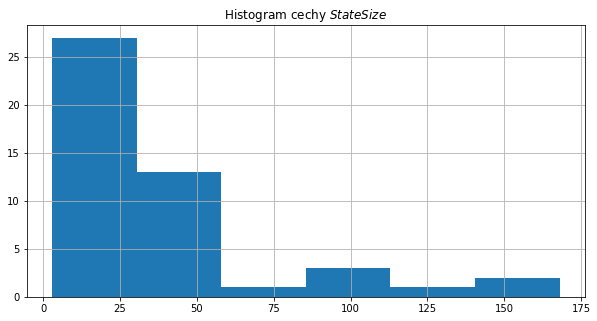

In [75]:
hist = df1.hist(column='StateSize', bins=6)
plt.title("Histogram cechy $\it{StateSize}$")
plt.show()

## Wykres pudełkowy

Wygodnym narzędziem graficznej interpretacji danych statystycznych jest wykres pudełkowy, na którym dla wybranej cechy oznaczone są wartości pierwszego kwartylu ($Q1$), mediany oraz trzeciego kwartylu ($Q3$) (tworzące *pudełko*), a *wąsy* mają maksymalną długość półtora rozstępu międzykwartylowego: $IQR=1.5\cdot(Q3-Q1)$. Na wykresach tego typu można porównać parametry statystyczne cechy pomiędzy różnymi grupami obserwacji, np. w stanach południowych i niepołudniowych.

#### Porównanie poziomu bezrobocia wśród młodych i  współczynnika przestępczości w zależności od położenia stanu na południu lub nie

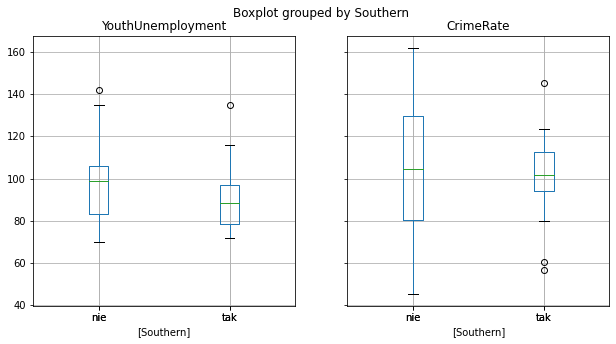

In [76]:
boxpl1 = df1.boxplot(column=['YouthUnemployment', 'CrimeRate'], by=['Southern'])

Parametry bezrobocia wśród młodych są do siebie zbliżone w obu rodzajach stanów. Natomiast współczynnik przestępczości ma ponaddwukrotnie mniejszy rozstęp międzykwartylowy w stanach południowych, co świadczy o większej koncentracji obserwacji.

#### Porównanie wartości współczynnika przestępczości w zależności od przewagi liczebnej mężczyzn w stanie

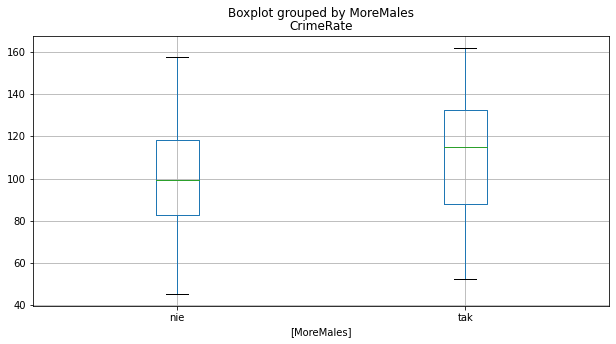

In [77]:
boxpl12 = df1.boxplot(column=['CrimeRate'], by=['MoreMales'])

Różnice we współczynniku przestępczości nie są znaczne, wartości maksymalne i minimalne są bardzo zbliżone, natomiast w stanach, w których mieszka więcej mężczyzn niż kobiet, mamy większą medianę i trzeci kwartyl współczynnika.

#### Porównanie liczby ludności  w stanach z wysokim i niskim wskaźnikiem bezrobocia wśród młodych mężczyzn w stosunku do dojrzałych mężczyzn

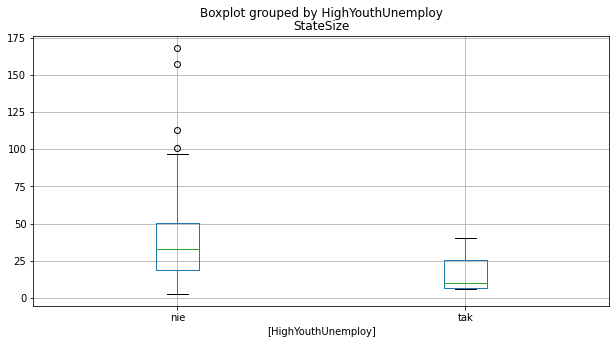

In [78]:
boxpl3 = df1.boxplot(column=['StateSize'], by=['HighYouthUnemploy'])

Stany z niskim wskaźnikiem bezrobocia młodzi/dojrzali mają zróżnicowaną liczbę ludności -- w $75\%$ poniżej 5 milionów, natomiast zdarzają się wartości odstające sięgające powyżej 15 milionów. Stany z wysokim wskaźnikiem bezrobocia młodzi/dojrzali są stosunkowo małe -- w $75\%$ poniżej $2.5$ miliona mieszkańców.

# Testy parametryczne

## Test t-Studenta dla danych zależnych

Porównana zostanie wartość współczynnika przestępczości w roku 0 (kiedy pierwszy raz przeprowadzono badania) i po 10 latach w różnych stanach USA. Są to dane zależne, ponieważ opisują ten sam parametr dla tej samej grupy stanów, ale w innym czasie. Liczność każdej z grup próbek wynosi $47$, więc przekracza wymaganą dla testu wartość ok. 20-25 obserwacji.

In [79]:
x0 = df1['CrimeRate']
x1 = df2['CrimeRate10']

Aby móc zastosować parowy test t-Studenta dla danych zależnych, należy zweryfikować założenie o normalności rozkładu różnic w grupach. Wykorzystany zostanie do tego test Shapiro-Wilka z hipotezą zerową, że dane pochodzą z rozkładu normalnego. Założony poziom istotności $\alpha = 0.05$.

In [80]:
alpha = 0.05
diff = x0 - x1
statistic, pval = shapiro(diff)
print(pval <= alpha)

False


Ponieważ p wartość testu Shapiro-Wilka jest większa niż założony poziom istotności testu, nie ma podstaw do odrzucenia hipotezy o normalnym rozkładzie różnic pomiędzy testowanymi grupami. Można zatem wykonać test t-Studenta z poziomem istotności $\alpha=0.05$.

**Hipoteza zerowa**: brak statystycznie istotnych różnic między średnimi wartościami współczynnika przestępczości w roku 0 i po 10 latach.

In [81]:
alpha = 0.05
statistic, pval = ttest_rel(x0, x1)
print(pval <= alpha)

False


Brak podstaw do odrzucenia hipotezy zerowej, zatem nie można stwierdzić, że w statystycznym sensie średni współczynnik przestępczości na przestrzeni 10 lat zmienił się.

## Test t-Studenta dla danych niezależnych

Testy danych niezależnych porównują ten sam parametr dla różnych grup. Przeanalizowana zostanie średnia liczba lat edukacji mieszkańca przed osiągnięciem 25 roku życia w stanach południowych i niepołudniowych. Na początek zbadane zostanie (testem Shapiro-Wilka z $\alpha=0.05$), czy dane w obu grupach pochodzą z rozkładu normalnego.

In [102]:
x0 = df1['Education'][df1['Southern']=='tak']
x1 = df1['Education'][df1['Southern']=='nie']
alpha = 0.05
statistic1, pval1 = shapiro(x0)
statistic2, pval2 = shapiro(x1)
print(pval1 <= alpha, pval2 <= alpha)

False False


Brak podstaw do odrzucenia H0 mówiącej o normalności rozkładów x0 i x1, zatem spełnione jest pierwsze założenie testu t-Studenta dla danych niezależnych. W drugim kroku zostanie zbadana równość wariancji w obu grupach. Wykorzystany zostanie tutaj test Bartletta o poziomie istotności $\alpha=0.05$ z H0, że obie próbki pochodzą z populacji o równych wariancjach.

In [103]:
statistic, pval = bartlett(x0, x1)
print(pval <= alpha)

False


Brak podstaw do odrzucenia hipotezy zerowej -- spełnione drugie założenie t-testu dla danych niezależnych. Można zatem wykonać test t-Studenta z poziomem istotności $\alpha=0.05$.

**Hipoteza zerowa**: brak statystycznie istotnych różnic między średnią liczbą lat edukacji do 25 roku życia w stanach południowych i niepołudniowych.

In [104]:
statistic, pval = ttest_ind(x0, x1)
print(pval <= alpha)

True


Wobec p wartości mniejszej od zadanego progu istotności należy przyjąć hipotezę alternatywną: istnieje statystycznie istotna różnica w średniej liczbie lat edukacji pomiędzy stanami południowymi a pozostałymi.

In [108]:
print("W stanach południowych młodzież średnio uczy się {mean0:.1f} lat, a w pozostałych stanach {mean1:.1f} i jest to statystycznie istotna różnica.".format(mean0 = x0.mean(), mean1 = x1.mean()))

W stanach południowych młodzież średnio uczy się 11.6 lat, a w pozostałych stanach 12.8 i jest to statystycznie istotna różnica.


## ANOVA

ANOVA jest testem parametrycznym, który (wykorzystując analizę wariancji) pozwala porównać średnie w wielu niezależnych grupach obserwacji. Reprezentowane w danych stany USA uszeregowano względem liczby ludności i podzielono na trzy części: stany małe (15 stanów), średnie (15 stanów) i duże (17 stanów). Na tej podstawie utworzono trzy niezależne od siebie grupy obserwacji: liczba pracujących młodych mężczyzn w wieku 18-24 (na 1000 młodych mężczyzn) w stanach małych, w stanach średnich, w stanach dużych.

Kolejno zbadano założenia testu parametrycznego ANOVA:
1. normalność rozkładu w każdej z grup,
2. równość wariancji pomiędzy grupami.

Do zbadania pierwszej hipotezy zerowej posłużył test Shapiro-Wilka z poziomem istotności $\alpha=0.05$, natomiast do określenia prawdziwości hipotezy zerowej mówiącej o równości wariancji wykorzystano test Bartletta, również z $\alpha=0.05$. Wyniki nie dają podstaw do odrzucenia żadnej z hipotez, ponieważ otrzymane p wartości są zbyt duże. Płynącym z tego wnioskiem jest, że można wykonać test ANOVA, jako że jego założenia są spełnione.

In [111]:
orderedStateSizes = df1['StateSize'].sort_values()
smallStateInd = orderedStateSizes[:15].index
mediumStateInd = orderedStateSizes[15:30].index
largeStateInd = orderedStateSizes[30:47].index
x0 = df1['LabourForce'][smallStateInd]
x1 = df1['LabourForce'][mediumStateInd]
x2 = df1['LabourForce'][largeStateInd]
alpha = 0.05
statistic1, pval1 = shapiro(x0)
statistic2, pval2 = shapiro(x1)
statistic3, pval3 = shapiro(x2)
print(pval1 <= alpha, pval2 <= alpha, pval3 <= alpha)
statistic4, pval4 = bartlett(x0, x1, x2)
print(pval4 <= alpha)

False False False
False


**Hipoteza zerowa**: średnio tyle samo młodych mężczyzn pracuje w stanach małych, w stanach średnich, a także w stanach dużych.

In [114]:
alpha = 0.05
statistic, pval = f_oneway(x0, x1, x2)
print(pval <= alpha)
print("W stanach małych pracuje średnio {mean0:.0f} młodych mężczyzn na 1000 młodych mężczyzn, w stanach średnich - {mean1:.0f}, a w stanach dużych - {mean2:.0f}. Brak statystycznie istotnej różnicy między tymi wartościami.".format(mean0 = x0.mean(), mean1 = x1.mean(), mean2 = x2.mean()))

False
W stanach małych pracuje średnio 576 młodych mężczyzn na 1000 młodych mężczyzn, w stanach średnich - 551, a w stanach dużych - 557. Brak statystycznie istotnej różnicy między tymi wartościami.


Przy przyjętym poziomie istotnośći $\alpha=0.05$ brak podstaw do odrzucenia hipotezy zerowej o równości średnich w trzech grupach.

# Testy nieparametryczne

## Test Wilcoxona

Test Wilcoxona jest alternatywą dla parowego testu t-Studenta dla danych zależnych, kiedy różnice pomiędzy dwiema grupami nie mają rozkładu normalnego. Rozważmy dwie grupy: liczbę rodzin żyjących w ubóstwie (za kwotę poniżej połowy przeciętnego tygodniowego wynagrodzenia; na 1000 rodzin) w różnych stanach USA w roku 0 i 10 lat później. Test Shapiro-Wilka na poziomie istotności $\alpha=0.05$ pozwala odrzucić hipotezę zerową o normalności rozkładu różnic w grupach.  

In [89]:
x0 = df1['BelowWage']
x1 = df2['BelowWage10']
alpha = 0.05
diff = x0 - x1
statistic, pval = shapiro(diff)
print(pval <= alpha)

True


**Hipoteza zerowa**: liczba rodzin żyjących w ubóstwie w roku 0 i po 10 latach ma ten sam rozkład i tę samą medianę.

In [90]:
alpha = 0.05
statistic, pval = wilcoxon(x0, x1)
print(pval <= alpha)

False


Otrzymana p wartość nie jest mniejsza lub równa od zadanego poziomu istotności, zatem nie można odrzucić hipotezy zerowej.

## Test Manna-Whitneya

Test Manna-Whitneya jest nieparametryczną wersją testu t-Studenta dla danych niezależnych. Nie wymaga on założenia o normalności rozkładu wśród grup. Do testu wybrane zostały próbki reprezentujące liczbę mieszkańców żyjących w ubóstwie w zależności od położenia stanu: południowego lub nie, są one wzajemnie niezależne. Test Shapiro-Wilka pozwoli określić, czy rozkłady w grupach można uznać za normalne.

In [91]:
x0 = df1['BelowWage'][df1['Southern']=='tak']
x1 = df1['BelowWage'][df1['Southern']=='nie']
alpha = 0.05
statistic1, pval1 = shapiro(x0)
statistic2, pval2 = shapiro(x1)
print(pval1 <= alpha, pval2 <= alpha)

True False


W grupie stanów południowych odrzucono hipotezę zerową o normalności rozkładu cechy *BelowWage*, zatem test Manna-Whitneya jest dobrym wyborem do badania statystycznego ($\alpha=0.05$).

**Hipoteza zerowa**: rozkład liczby osób w ubóstwie jest taki sam wśród stanów południowych i wśród stanów niepołudniowych.

In [92]:
alpha = 0.05
statistic, pval = mannwhitneyu(x0, x1)
print(pval <= alpha)

True


Dzięki odpowiednio małej wartości p hipoteza zerowa została odrzucona na rzecz hipotezy alternatywnej: rozkład cechy *BelowWage* jest inny dla stanów południowych, a inny dla stanów nieleżących na południu. Werdykt testu można potwierdzić, rysując odpowiednie histogramy.

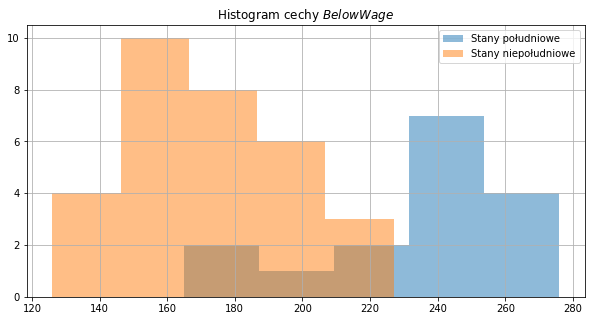

In [93]:
h1 = x0.hist(bins=5, alpha=0.5)
h2 = x1.hist(bins=5, alpha=0.5)
plt.title("Histogram cechy $\it{BelowWage}$")
plt.legend(["Stany południowe", "Stany niepołudniowe"])
plt.show()